In [1]:
import shap
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
import io
import warnings

In [2]:
import seaborn as sns

# Try considering only calcifications ipsilateral to symptoms

In [15]:
df_orig = pd.read_csv("../../input/calcifications.csv")

In [16]:
df_orig = df_orig.drop(["site", "patient_ID", "stroke", "TIA", "tabulator"], axis=1)

In [17]:
df_orig.loc[:, "calcification_type"] = df_orig.apply(lambda v: v["calcification_type_left"] if v["infarct_side"] == "left" else v["calcification_type_right"], axis=1)

In [18]:
df_orig = df_orig.drop(["calcification_type_right", "calcification_type_left"], axis=1)

In [19]:
!ls

Comparison ROC AUCs.ipynb
EBM.ipynb
Examine errors.ipynb
Explore baseline classifiers.ipynb
Interpreting predictions for CEVEP.ipynb
Interpreting predictions.ipynb
ROC and PR curves.Rmd
Statistical Analysis.Rmd
__pycache__
preprocessing and train test split.ipynb


In [20]:
df_orig.to_csv("../input/calcification_one_side.csv", index=False)

In [31]:
ext_orig = pd.read_csv("../input/external.csv")
train_orig = pd.read_csv("../input/train.csv")

train_orig = train_orig.drop(["site", "patient_ID", "infarct_side", "stroke", "TIA"], axis=1)
ext_orig = ext_orig.drop(["site", "infarct_side", "stroke", "TIA",], axis=1)

In [32]:
train_orig.columns

Index(['calcification_type_right', 'calcification_type_left', 'symptoms',
       'hypertension', 'cad', 'smoker_status', 'age', 'gender', 'diabetes',
       'hyperlipidemia', 'stenosis_right', 'stenosis_left'],
      dtype='object')

In [33]:
ext_orig.columns

Index(['calcification_type_right', 'calcification_type_left', 'symptoms',
       'hypertension', 'cad', 'smoker_status', 'age', 'gender', 'diabetes',
       'hyperlipidemia', 'stenosis_right', 'stenosis_left'],
      dtype='object')

In [36]:
pd.concat([train_orig, ext_orig], axis=0).to_csv("../input/train_test.csv", index=False)

# Misc

In [3]:
columns_map = {
    "TIA": "TIA",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Is Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "symptoms": "Symptoms",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_right": "Stenosis (Right)",
    "stenosis_left": "Stenosis (Left)",
    'calcification_left_Type1':'Calcification (L)',
    'calcification_left_Type2': 'Type 2 - Intimal or Superficial (L)',
    'calcification_left_Type3':'Type 3 - Deep or Bulky (L)',
    'calcification_left_Type4':'Type 4 - Adventitial (L)',
    'calcification_left_Type5':'Type 5 - Mixed Intimal and Bulky (L)',
    'calcification_left_Type6':'Type 6 - Positive Rim Sign (L)',
    'calcification_right_Type1':'Calcification (R)',
    'calcification_right_Type2': 'Type 2 - Intimal or Superficial (R)',
    'calcification_right_Type3':'Type 3 - Deep or Bulky (R)',
    'calcification_right_Type4':'Type 4 - Adventitial (R)',
    'calcification_right_Type5':'Type 5 - Mixed Intimal and Bulky (R)',
    'calcification_right_Type6':'Type 6 - Positive Rim Sign (R)'    
}

In [4]:
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
blue = "#4974a5"
lightblue = "#b0c4de"
salmon = "#ff8c69"
lightsalmon = "#FFA385"
darksalmon = "#e57e5e"

#custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [lightblue, salmon], N=256)

sienna = "#EA7E5D"
blue_yonder = "#4974A5"
coral = "#FF8C69"
orangesoda = "#E46C4E" 
fire = "#E26756"
violet = "#BF5FB2"
yellow = "#FFDE81"
green = "#0CCC9C"
green2 = "#82B240"
green2darker = "#638731"
charcoal = "#31485D"
queen_blue = "#466786"

# text: #484E51
#colors = [blue_yonder, coral, violet, green2, yellow]
colors = [blue_yonder, fire, violet, green2, yellow]

custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', [green2, fire], N=256)

# Load model and predictions

In [5]:
with open(f'../output/fitted_models/ebm_all.pkl', 'rb') as fr:
    model = pickle.load(fr)

# Load training set

In [6]:
train = pd.read_csv("../input/train.csv")
X_train, y_train = train.drop('symptoms', axis=1), train['symptoms']

X_train = X_train.drop(["site", "patient_ID", "infarct_side", "stroke", "TIA"], axis=1)
X_train_nr = X_train.copy()

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["hypertension", "cad", "gender", "diabetes", "hyperlipidemia", "smoker_status"]

to_ohe = ["calcification_type_left", "calcification_type_right"]
prefixes = ["calcification_left", "calcification_right"]
X_train_nr = pd.get_dummies(X_train_nr, 
                   columns=to_ohe, prefix=prefixes)

y_train = le.fit_transform(y_train)
X_train_nr[to_encode] = oe.fit_transform(X_train_nr[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_train_nr.select_dtypes(include=np.uint8).columns.tolist()
X_train_nr[cat_cols] = X_train_nr[cat_cols].astype("category")

X_train_renamed = X_train_nr.rename(columns=columns_map)
X_train_nr = X_train_nr.rename(columns=columns_map)

X_train_fancy = X_train_nr.copy()
bin_features = X_train_fancy.select_dtypes(include="category").columns.tolist()
for c in bin_features:
    X_train_fancy[c] = X_train_fancy[c].apply(lambda v: "Yes" if v == 1 else "No")

In [ ]:
train = pd.read_csv("../input/train_preprocessed.csv")
X_train, y_train = train.drop("symptoms", axis=1), train.symptoms

# Load external validation set

In [7]:
test = pd.read_csv("../input/external.csv")
X_test, y_test = test.drop('symptoms', axis=1), test['symptoms']

X_test = X_test.drop(["site", "infarct_side", "stroke", "TIA"], axis=1)
X_test_nr = X_test.copy()

le = LabelEncoder()
oe = OrdinalEncoder()

to_encode = ["hypertension", "cad", "gender",
             #"TIA", 
             "diabetes", "hyperlipidemia", "smoker_status",
             #"prs_either", 
             #'prs_left', 'prs_right',
             #'calc_and_lipids', 'at_least_5_and_stenosis_either',
             #'at_least_5_and_stenosis_left', 'at_least_5_and_stenosis_right'
            ]

to_ohe = ["calcification_type_left", "calcification_type_right" 
          #'stenosis_risk_left', 'stenosis_risk_right'
         ]
prefixes = ["calcification_left", "calcification_right" 
            #'stenosis_risk_left', 'stenosis_risk_right'
           ]
X_test_nr = pd.get_dummies(X_test_nr, 
                   columns=to_ohe, prefix=prefixes)

y_test = le.fit_transform(y_test)
X_test_nr[to_encode] = oe.fit_transform(X_test_nr[to_encode]).astype(np.uint8)

# convert uint8 dtypes to categorical
cat_cols = X_test_nr.select_dtypes(include=np.uint8).columns.tolist()
X_test_nr[cat_cols] = X_test_nr[cat_cols].astype("category")

X_test_renamed = X_test_nr.rename(columns=columns_map)
X_test_nr = X_test_nr.rename(columns=columns_map)

X_test_fancy = X_test_nr.copy()
bin_features = X_test_fancy.select_dtypes(include="category").columns.tolist()
for c in bin_features:
    X_test_fancy[c] = X_test_fancy[c].apply(lambda v: "Yes" if v == 1 else "No")

In [8]:
external = pd.read_csv("../input/external_preprocessed.csv")
X_test_ohe, y_test = external.drop("symptoms", axis=1), external.symptoms

# Identify errors on external set

In [9]:
import seaborn as sns

In [10]:
threshold = 0.43496668724224646

y_test = pd.Series(y_test)
y_pred_proba_test = model.predict_proba(X_test_ohe)[:, 1]

labels = np.where(y_pred_proba_test >= threshold, 1, 0)
fn_mask = (labels == 0) & (y_test == 1)
fp_mask = (labels == 1) & (y_test == 0)
tp_mask = (labels == 1) & (y_test == 1)
tn_mask = (labels == 0) & (y_test == 0)

In [14]:
fp_mask.mean(), tn_mask.mean(), fn_mask.mean(), tp_mask.mean()

(0.389937106918239,
 0.22012578616352202,
 0.07547169811320754,
 0.31446540880503143)

In [264]:
fp_mask.sum(), tn_mask.sum(), fn_mask.sum(), tp_mask.sum()

(62, 35, 12, 50)

In [11]:
#calcs = X_test[[ "calcification_type_left", "calcification_type_right"]]
calcs = X_test.copy()
calcs["status"] = np.where(y_test == 1, "Symptomatic", "Asymptomatic")

# mark errors
calcs.loc[fn_mask | fp_mask, "category"] = "Misclassified"

# mark correct
calcs.loc[tp_mask | tn_mask, "category"] = "Correct"

In [12]:
calcs.loc[:, "gender"] = calcs.loc[:, "gender"].map({"male": "Yes", "female": "No"})
calcs.loc[:, "smoker_status"] = calcs.loc[:, "smoker_status"].map({"yes": "Yes", "no": "No"})

for c in ["hypertension", "cad", "diabetes", "hyperlipidemia"]:
    calcs.loc[:, c] = calcs.loc[:, c].map({"yes": "Present", "no": "Absent"})

In [17]:
calcs

,calcification_type_right,calcification_type_left,hypertension,cad,smoker_status,age,gender,diabetes,hyperlipidemia,stenosis_right,stenosis_left,status,category
0,Type3,Type1,Present,Absent,No,56,Yes,Present,Present,40,75,Asymptomatic,Correct
1,Type1,Type1,Absent,Absent,Yes,50,No,Absent,Present,45,62,Asymptomatic,Misclassified
2,Type2,Type1,Present,Absent,Yes,73,Yes,Absent,Present,43,60,Asymptomatic,Misclassified
3,Type2,Type2,Absent,Absent,Yes,67,No,Absent,Present,20,10,Asymptomatic,Correct
4,Type1,Type1,Present,Absent,No,78,No,Present,Present,50,85,Asymptomatic,Correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Type6,Type3,Absent,Absent,Yes,59,No,Present,Present,67,23,Symptomatic,Correct
155,Type3,Type2,Absent,Absent,Yes,50,No,Absent,Present,43,56,Symptomatic,Correct
156,Type1,Type5,Present,Absent,No,75,Yes,Absent,Present,45,55,Symptomatic,Correct
157,Type1,Type1,Absent,Absent,Yes,60,Yes,Absent,Present,0,45,Symptomatic,Correct


In [13]:
calcs = calcs.rename(columns={
    "category": "Category",
    "status": "Status",
    "calcification_type_left": "Calcification Type (L)",
    "calcification_type_right": "Calcification Type (R)",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_left": "Stenosis (L)",
    "stenosis_right": "Stenosis (R)"    
})

train = train.rename(columns={
    "calcification_type_left": "Calcification Type (L)",
    "calcification_type_right": "Calcification Type (R)",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Smoker",
    "age": "Age",
    "gender": "Male",
    "diabetes": "Diabetes",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_left": "Stenosis (L)",
    "stenosis_right": "Stenosis (R)"
})

# Start with plots

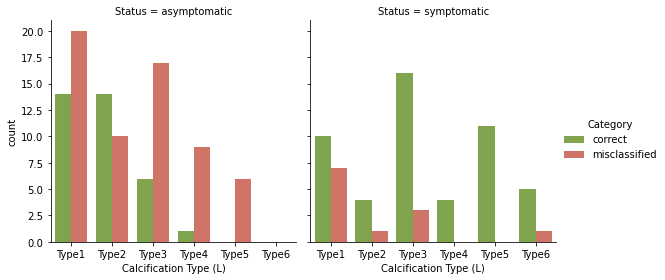

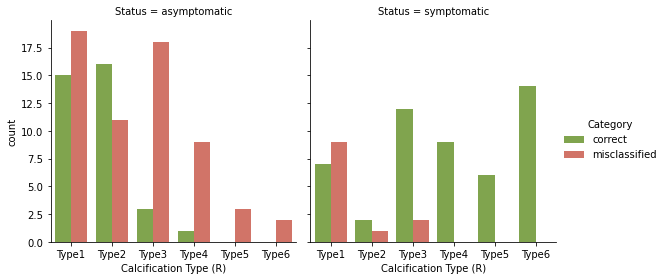

In [34]:
g1 = sns.catplot(x="Calcification Type (L)", hue="Category", col="Status",
                data=calcs, kind="count",
                order=["Type1", "Type2", "Type3", "Type4", "Type5", "Type6"],
                height=4, aspect=1,
                palette={"correct": green2, "misclassified": fire})

g2 = sns.catplot(x="Calcification Type (R)", hue="Category", col="Status",
                data=calcs, kind="count",
                order=["Type1", "Type2", "Type3", "Type4", "Type5", "Type6"],
                height=4, aspect=1,
                palette={"correct": green2, "misclassified": fire})

In [124]:
sub_calcs = calcs[calcs.status == "symptomatic"]
pd.crosstab(sub_calcs.category, sub_calcs.calcification_type_left,
           margins=True)

# 13/22 = 59% misclassificazioni (FN) in pazienti senza calcificazione

calcification_type_left,Type1,Type2,Type3,Type4,Type5,Type6,All
category,,,,,,,
correct,4,4,15,4,9,4,40
misclassified,13,1,4,0,2,2,22
All,17,5,19,4,11,6,62


In [125]:
pd.crosstab(sub_calcs.category, sub_calcs.calcification_type_right,
           margins=True)
# 15/22 = 68% misclassificazioni (FN) in pazienti senza calcificazione

calcification_type_right,Type1,Type2,Type3,Type4,Type5,Type6,All
category,,,,,,,
correct,1,0,11,8,6,14,40
misclassified,15,3,3,1,0,0,22
All,16,3,14,9,6,14,62


## False negatives analysis

### Categorical columns

In [170]:
train

,site,patient_ID,infarct_side,Calcification Type (R),Calcification Type (L),symptoms,stroke,TIA,Hypertension,CAD,Smoker,Age,Male,Diabetes,Hyperlipidemia,Stenosis (R),Stenosis (L)
0,Cagliari,Cagliari 1,left,Type1,Type1,yes,yes,no,no,no,yes,48,male,no,yes,5.0,10.0
1,Cagliari,Cagliari 11,right,Type3,Type2,yes,yes,no,yes,no,yes,81,female,no,yes,100.0,0.0
2,Cagliari,Cagliari 16,right,Type3,Type3,yes,yes,no,yes,no,yes,66,female,yes,yes,100.0,0.0
3,Cagliari,Cagliari 17,left,Type5,Type5,yes,yes,no,no,no,yes,75,female,no,yes,0.0,20.0
4,Cagliari,Cagliari 19,right,Type1,Type1,yes,yes,no,no,no,yes,41,male,no,yes,50.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,Cagliari,Cagliari 989,NC,Type1,Type1,no,no,no,no,no,yes,81,female,no,yes,0.0,25.0
786,Cagliari,Cagliari 990,NC,Type3,Type3,no,no,no,yes,no,yes,78,female,no,yes,0.1,0.5
787,Cagliari,Cagliari 996,NC,Type1,Type1,no,no,no,no,yes,no,86,male,yes,yes,100.0,0.0
788,Stanford,Stanford 1001,right,Type2,Type1,no,yes,no,yes,no,no,76,female,no,yes,50.0,50.0


In [171]:
# select all false negative errors
fns = calcs[(calcs.Status == "Symptomatic") & (calcs.Category == "Misclassified")]
#tps = calcs[(calcs.status == "symptomatic") & (calcs.category == "correct")]
#tns = calcs[(calcs.status == "asymptomatic") & (calcs.category == "correct")]

tns_train = train[train.symptoms == "no"].drop(["site", "patient_ID", 
                                                "infarct_side", "stroke", 
                                                "TIA", "symptoms"], axis=1)

In [173]:
fns_info = fns.describe(include = 'object').T[:-2].drop(["unique"], axis=1)
tns_info_train = tns_train.describe(include = 'object').T.drop(["unique"], axis=1)

In [174]:
fns_tns = pd.merge(fns_info, tns_info_train, left_index=True, right_index=True,
        suffixes=["_FNS", "_TNS"])

In [175]:
perc_fns = (fns_tns["freq_FNS"] / fns_tns["count_FNS"]) * 100
fns_tns.insert(loc=3, column="perc_FNS", value=perc_fns)

In [176]:
perc_tns = (fns_tns["freq_TNS"] / fns_tns["count_TNS"]) * 100
fns_tns.insert(loc=7, column="perc_TNS", value=perc_tns)

In [177]:
fns_tns

,count_FNS,top_FNS,freq_FNS,perc_FNS,count_TNS,top_TNS,freq_TNS,perc_TNS
Calcification Type (R),12,Type1,9,75.0,282,Type1,123,43.617021
Calcification Type (L),12,Type1,7,58.333333,282,Type1,131,46.453901
Hypertension,12,Absent,7,58.333333,282,yes,172,60.992908
CAD,12,Absent,10,83.333333,282,no,231,81.914894
Smoker,12,No,8,66.666667,282,no,160,56.737589
Male,12,No,9,75.0,282,female,159,56.382979
Diabetes,12,Absent,9,75.0,282,no,207,73.404255
Hyperlipidemia,12,Absent,9,75.0,282,yes,181,64.184397


In [ ]:
"""
What does 22 false negatives and true negatives have in common ?
our model misclassified 22 symptomatic patients as asymptomatic persons
almost half asymptomatic persons don't have calcification (43.6% and 46.4%)
(type 1 is most prevalent among asymptomatic persons, the model may have
learnt that if you don't have calcification then it is unlikely that
you are symptomatic)
also true for CAD, smoking, gender and diabetes

bottom line is, symptomatic patients misclassified as asymptomatic by the model
have characteristics very similar to asymptomatic patients in the training data
"""

In [ ]:
# how to fix: add symptomatic subjects with these characteristics

### Numeric columns

In [178]:
fns_info_num = fns.describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)
tns_info_train_num = train[train.symptoms == "no"].describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)

In [179]:
fns_tns_num = pd.merge(fns_info_num, tns_info_train_num, 
                       left_index=True, right_index=True,
                       suffixes=["_FNS", "_TNS"])

In [180]:
fns_tns_num

,mean_FNS,std_FNS,min_FNS,50%_FNS,max_FNS,mean_TNS,std_TNS,min_TNS,50%_TNS,max_TNS
Age,69.000000,7.698878,56.0,68.5,81.0,69.117021,13.323131,26.0,71.0,101.0
Stenosis (R),43.750000,23.768294,0.0,45.0,78.0,36.302128,40.401819,0.0,17.5,100.0
Stenosis (L),76.333333,12.390123,50.0,79.0,95.0,40.357482,40.812790,0.0,20.0,100.0


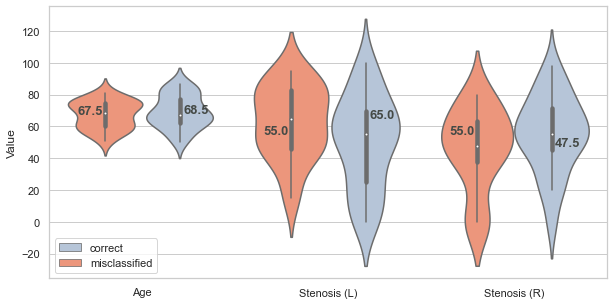

In [354]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
calcs_melt = pd.melt(calcs[calcs.Status == 'symptomatic'], id_vars="Category", value_vars=["Age", "Stenosis (L)", "Stenosis (R)"],)

yposlist1 = calcs_melt[calcs_melt.Category=="correct"].groupby(['variable'])['value'].median().tolist()
yposlist2 = calcs_melt[calcs_melt.Category=="misclassified"].groupby(['variable'])['value'].median().tolist()
xposlist = range(len(yposlist))

sns.violinplot(data=calcs_melt, y="value", x="variable", hue="Category",
              split=False, 
               palette={"correct": lightblue, "misclassified": salmon},
              inner="box", orient="v")

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[idx] for idx in [1, 0]],
          [labels[idx] for idx in [1, 0]],
          loc="lower left")

for i in xposlist:
    ax.text(xposlist[i]-0.35, yposlist1[i], yposlist1[i], color="#454a46", weight="bold", fontsize=13)
    ax.text(xposlist[i]+0.22, yposlist2[i], yposlist2[i], color="#454a46", weight="bold", fontsize=13)

ax.set_xlabel("")    
ax.set_ylabel("Value")
    
plt.show()

## False positive analysis

In [181]:
# select all false positive errors
fps = calcs[(calcs.Status == "Asymptomatic") & (calcs.Category == "Misclassified")]

tps_train = train[train.symptoms == "yes"].drop(["site", "patient_ID", 
                                                "infarct_side", "stroke", 
                                                "TIA", "symptoms"], axis=1)

In [182]:
fps_info = fps.describe(include = 'object').T[:-2].drop(["unique"], axis=1)
tps_info_train = tps_train.describe(include = 'object').T.drop(["unique"], axis=1)

In [183]:
fps_tps = pd.merge(fps_info, tps_info_train, 
                   left_index=True, 
                   right_index=True,
                   suffixes=["_FPS", "_TPS"])

perc_fps = (fps_tps["freq_FPS"] / fps_tps["count_FPS"]) * 100
fps_tps.insert(loc=3, column="perc_FPS", value=perc_fps)

perc_tps = (fps_tps["freq_TPS"] / fps_tps["count_TPS"]) * 100
fps_tps.insert(loc=7, column="perc_TPS", value=perc_tps)

fps_tps

,count_FPS,top_FPS,freq_FPS,perc_FPS,count_TPS,top_TPS,freq_TPS,perc_TPS
Calcification Type (R),62,Type1,19,30.645161,508,Type3,166,32.677165
Calcification Type (L),62,Type1,20,32.258065,508,Type3,170,33.464567
Hypertension,62,Present,36,58.064516,508,yes,331,65.15748
CAD,62,Absent,57,91.935484,508,no,407,80.11811
Smoker,62,Yes,37,59.677419,508,no,260,51.181102
Male,62,No,38,61.290323,508,female,299,58.858268
Diabetes,62,Absent,49,79.032258,508,no,383,75.393701
Hyperlipidemia,62,Present,51,82.258065,508,yes,392,77.165354


FPS: false positives. Actually asymptomatic persons misclassified as symptomatic.

In the external validation set there are a good number of asymptomatic
persons with the same characteristics of symptomatic patients in the
training set. 

### Numeric columns

In [184]:
fps_info_num = fps.describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)
tps_info_train_num = train[train.symptoms == "yes"].describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)

In [185]:
fps_tps_num = pd.merge(fps_info_num, tps_info_train_num, 
                       left_index=True, right_index=True,
                       suffixes=["_FPS", "_TPS"])

In [186]:
fps_tps_num

,mean_FPS,std_FPS,min_FPS,50%_FPS,max_FPS,mean_TPS,std_TPS,min_TPS,50%_TPS,max_TPS
Age,68.806452,8.758768,49.0,68.5,84.0,70.088583,14.332830,23.0,73.0,102.0
Stenosis (R),47.080645,28.190975,0.0,47.5,95.0,40.136658,41.878699,0.0,25.0,100.0
Stenosis (L),46.483871,28.030278,0.0,54.5,100.0,41.031894,41.906881,0.0,25.0,100.0


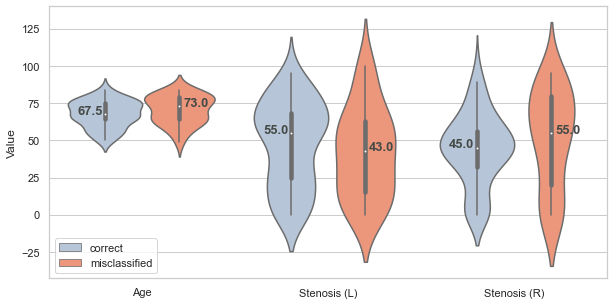

In [346]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
calcs_melt = pd.melt(calcs[calcs.Status == 'asymptomatic'], id_vars="Category", value_vars=["Age", "Stenosis (L)", "Stenosis (R)"],)

yposlist1 = calcs_melt[calcs_melt.Category=="correct"].groupby(['variable'])['value'].median().tolist()
yposlist2 = calcs_melt[calcs_melt.Category=="misclassified"].groupby(['variable'])['value'].median().tolist()
xposlist = range(len(yposlist))

sns.violinplot(data=calcs_melt, y="value", x="variable", hue="Category",
              split=False, 
               palette={"correct": lightblue, "misclassified": salmon},
              inner="box", orient="v")
ax.legend(loc="lower left")

for i in xposlist:
    ax.text(xposlist[i]-0.35, yposlist1[i], yposlist1[i], color="#454a46", weight="bold", fontsize=13)
    ax.text(xposlist[i]+0.22, yposlist2[i], yposlist2[i], color="#454a46", weight="bold", fontsize=13)

ax.set_xlabel("")    
ax.set_ylabel("Value")
    
plt.show()

### False negatives and false positives together

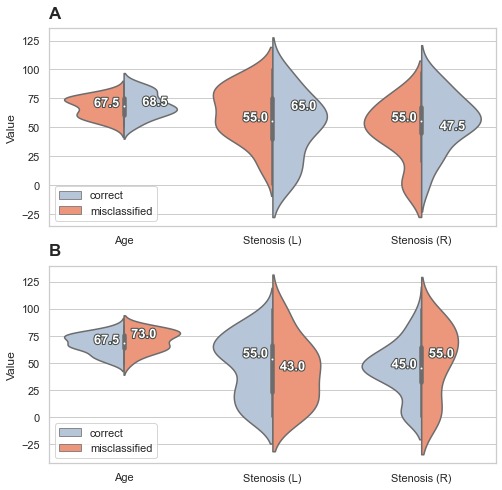

In [482]:
import matplotlib.patheffects as PathEffects

f, ax = plt.subplots(2, 1, figsize=(8, 8))

sns.set_theme(style="whitegrid")
calcs_melt = pd.melt(calcs[calcs.Status == 'symptomatic'], id_vars="Category", value_vars=["Age", "Stenosis (L)", "Stenosis (R)"],)

yposlist1 = calcs_melt[calcs_melt.Category=="correct"].groupby(['variable'])['value'].median().tolist()
yposlist2 = calcs_melt[calcs_melt.Category=="misclassified"].groupby(['variable'])['value'].median().tolist()
xposlist = range(len(yposlist))

sns.violinplot(data=calcs_melt, y="value", x="variable", hue="Category",
              split=True, 
               palette={"correct": lightblue, "misclassified": salmon},
              inner="box", orient="v", ax=ax[0])

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend([handles[idx] for idx in [1, 0]],
          [labels[idx] for idx in [1, 0]],
          loc="lower left")

for i in xposlist:
    t1 = ax[0].text(xposlist[i]-0.20, yposlist1[i], yposlist1[i], color="w", weight="bold", fontsize=13)
    t2 = ax[0].text(xposlist[i]+0.125, yposlist2[i], yposlist2[i], color="w", weight="bold", fontsize=13)
    t1.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='#454a46')])
    t2.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='#454a46')])

ax[0].set_xlabel("")    
ax[0].set_ylabel("Value")
    
#####
calcs_melt = pd.melt(calcs[calcs.Status == 'asymptomatic'], id_vars="Category", value_vars=["Age", "Stenosis (L)", "Stenosis (R)"],)

yposlist1 = calcs_melt[calcs_melt.Category=="correct"].groupby(['variable'])['value'].median().tolist()
yposlist2 = calcs_melt[calcs_melt.Category=="misclassified"].groupby(['variable'])['value'].median().tolist()
xposlist = range(len(yposlist))

sns.violinplot(data=calcs_melt, y="value", x="variable", hue="Category",
              split=True, 
               palette={"correct": lightblue, "misclassified": salmon},
              inner="box", orient="v", ax=ax[1])
ax[1].legend(loc="lower left")

for i in xposlist:
    t1 = ax[1].text(xposlist[i]-0.20, yposlist1[i], yposlist1[i], color="w", weight="bold", fontsize=13)
    t2 = ax[1].text(xposlist[i]+0.05, yposlist2[i], yposlist2[i], color="w", weight="bold", fontsize=13)
    t1.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='#454a46')])
    t2.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='#454a46')])    

ax[1].set_xlabel("")    
ax[1].set_ylabel("Value")

ax[0].text(0, 1.05, "A", transform=ax[0].transAxes, size=17, weight='bold')
ax[1].text(0, 1.05, "B", transform=ax[1].transAxes, size=17, weight='bold')

plt.savefig("../output/plots/TIFF/correct_vs_error_numeric.tiff", format="tiff", dpi=1200, bbox_inches='tight',
           pil_kwargs={"compression": "tiff_lzw"})

plt.show()

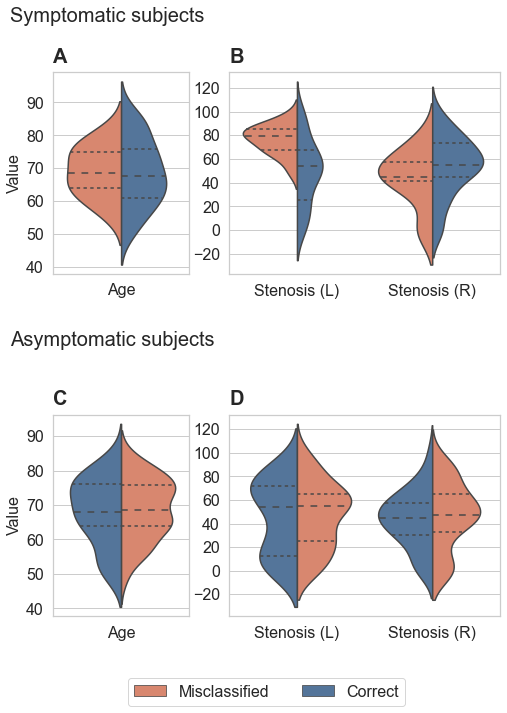

In [257]:
import matplotlib.patheffects as PathEffects
from matplotlib import gridspec

palette = {"Correct": blue_yonder, "Misclassified": sienna}

sns.set_theme(style="whitegrid")

f = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])

### First row, symptomatic patients and false negatives
calcs_melt = pd.melt(calcs[calcs.Status == 'Symptomatic'], 
                     id_vars="Category", 
                     value_vars=["Age", "Stenosis (L)", "Stenosis (R)"],)

yposlist1 = calcs_melt[calcs_melt.Category=="Correct"].groupby(['variable'])['value'].median().tolist()
yposlist2 = calcs_melt[calcs_melt.Category=="Misclassified"].groupby(['variable'])['value'].median().tolist()
xposlist = range(len(yposlist1))

# Age
ax0 = plt.subplot(gs[0])
sns.violinplot(data=calcs_melt[calcs_melt["variable"] == "Age"], y="value", x="variable", hue="Category",
               split=True, palette=palette,
               inner="quartile", orient="v", ax=ax0)

# Steosis left and right
ax1 = plt.subplot(gs[1])
sns.violinplot(data=calcs_melt[calcs_melt["variable"] != "Age"], y="value", x="variable", hue="Category",
               split=True, palette=palette,
               inner="quartile", orient="v", ax=ax1)

#handles, labels = ax[0].get_legend_handles_labels()
#ax[0].legend([handles[idx] for idx in [1, 0]],
#          [labels[idx] for idx in [1, 0]],
#          loc="lower left")


#for i in xposlist:
#    t1 = ax[0].text(xposlist[i]-0.20, yposlist1[i], yposlist1[i], color="w", weight="bold", fontsize=13)
#    t2 = ax[0].text(xposlist[i]+0.125, yposlist2[i], yposlist2[i], color="w", weight="bold", fontsize=13)
#    t1.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='#454a46')])
#    t2.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='#454a46')])

### Second row, asymptomatic persons and false positives
calcs_melt = pd.melt(calcs[calcs.Status == 'Asymptomatic'], 
                     id_vars="Category", 
                     value_vars=["Age", "Stenosis (L)", "Stenosis (R)"],)

# Age
ax2 = plt.subplot(gs[2])
sns.violinplot(data=calcs_melt[calcs_melt["variable"] == "Age"], y="value", x="variable", hue="Category",
               split=True, palette=palette,
               inner="quartile", orient="v", ax=ax2)

# Stenosis left and right
ax3 = plt.subplot(gs[3])
sns.violinplot(data=calcs_melt[calcs_melt["variable"] != "Age"], y="value", x="variable", hue="Category",
               split=True, palette=palette,
               inner="quartile", orient="v", ax=ax3)
    
# Draw single legend outside
handles, labels = ax0.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(0.75,0.05), 
         ncol=2, fontsize=16)    


for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlabel("")    
    ax.set_ylabel("Value")
    ax.get_legend().remove()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)    
        
ax1.set_ylabel("")
ax3.set_ylabel("")
ax0.text(0, 1.05, "A", transform=ax0.transAxes, size=20, weight='bold')
ax1.text(0, 1.05, "B", transform=ax1.transAxes, size=20, weight='bold')
ax2.text(0, 1.05, "C", transform=ax2.transAxes, size=20, weight='bold')
ax3.text(0, 1.05, "D", transform=ax3.transAxes, size=20, weight='bold')

f.text(0.05, 0.95, "Symptomatic subjects", size=20, weight='normal')
f.text(0.05, 0.5, "Asymptomatic subjects", size=20, weight='normal')

plt.subplots_adjust(hspace=0.7)

plt.savefig("../output/plots/correct_vs_error_numeric.tiff", format="tiff", dpi=500, 
            bbox_inches='tight',
           pil_kwargs={"compression": "tiff_lzw"})

plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

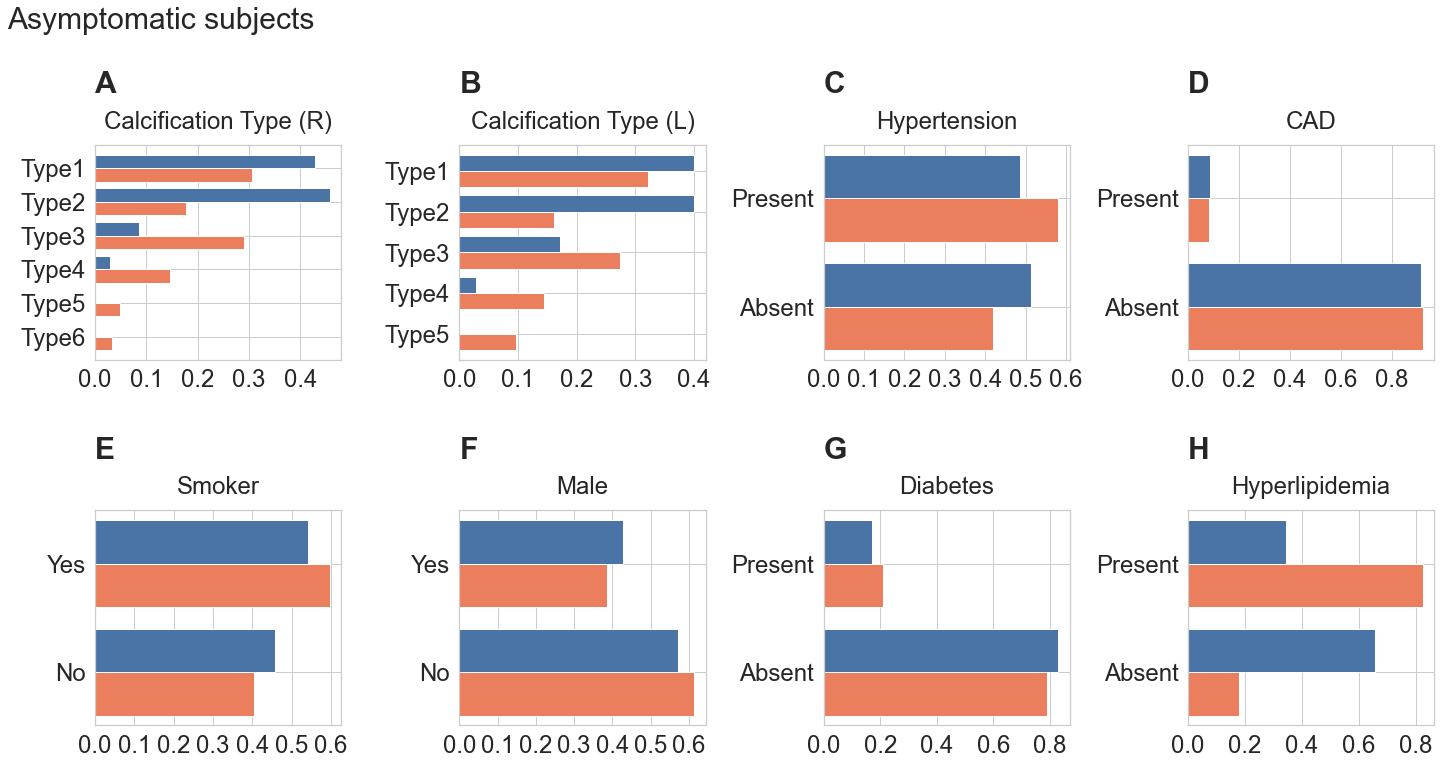

In [20]:
from string import ascii_uppercase

palette = {"Correct": blue_yonder, "Misclassified": sienna}

sns.set_theme(style="whitegrid")

to_drop = ["Age", "Stenosis (L)", "Stenosis (R)", "Status"]

# false positives
df = calcs[calcs.Status == 'Asymptomatic'].drop(to_drop, axis=1)

calcs_melt_cat = pd.melt(df, id_vars="Category")

f, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()

for c, ax in zip(calcs_melt_cat.variable.unique(), axes[:8]):
    #ax.title.set_text(c)
    col_data_with_ordering = calcs_melt_cat[calcs_melt_cat.variable==c]
    
    if "Calcification" in c:
        order = ["Type1", "Type2", "Type3", "Type4", "Type5", "Type6"]
    elif c in ["Smoker", "Male"]:
        order = ["Yes", "No"]
    else:
        order = ["Present", "Absent"]
    col_data_with_ordering.loc[:, "value"] = pd.Categorical(col_data_with_ordering.loc[:, "value"], order).copy()
    
    sns.histplot(y="value",
                data=col_data_with_ordering,
                hue="Category",
                #order=order,
                palette=palette,
                stat="probability", common_norm=False,
                 multiple="dodge",
                 alpha=1,
                 shrink=.8,
                ax=ax)
    ax.set_title(c, pad=16)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.get_legend().remove()   
    
f.text(0, 1.03, "Asymptomatic subjects", size=30, weight='normal')

    
handles, labels = ax.get_legend_handles_labels()
#f.legend(handles, labels, bbox_to_anchor=(0.61, -0.03), 
#         ncol=2, fontsize=16, prop={"size": 24})

for ax, letter in zip(axes, ascii_uppercase):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    
    
    ax.text(0, 1.24, letter, transform=ax.transAxes, size=30, weight='bold')

        
#axes[0].text(0, -1.8, "A", size=25, weight='bold')
#axes[8].text(0, -1.8, "B", size=25, weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)


#plt.savefig("../output/plots/correct_vs_error_categorical_fp.tiff", format="tiff", dpi=500, 
#            bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

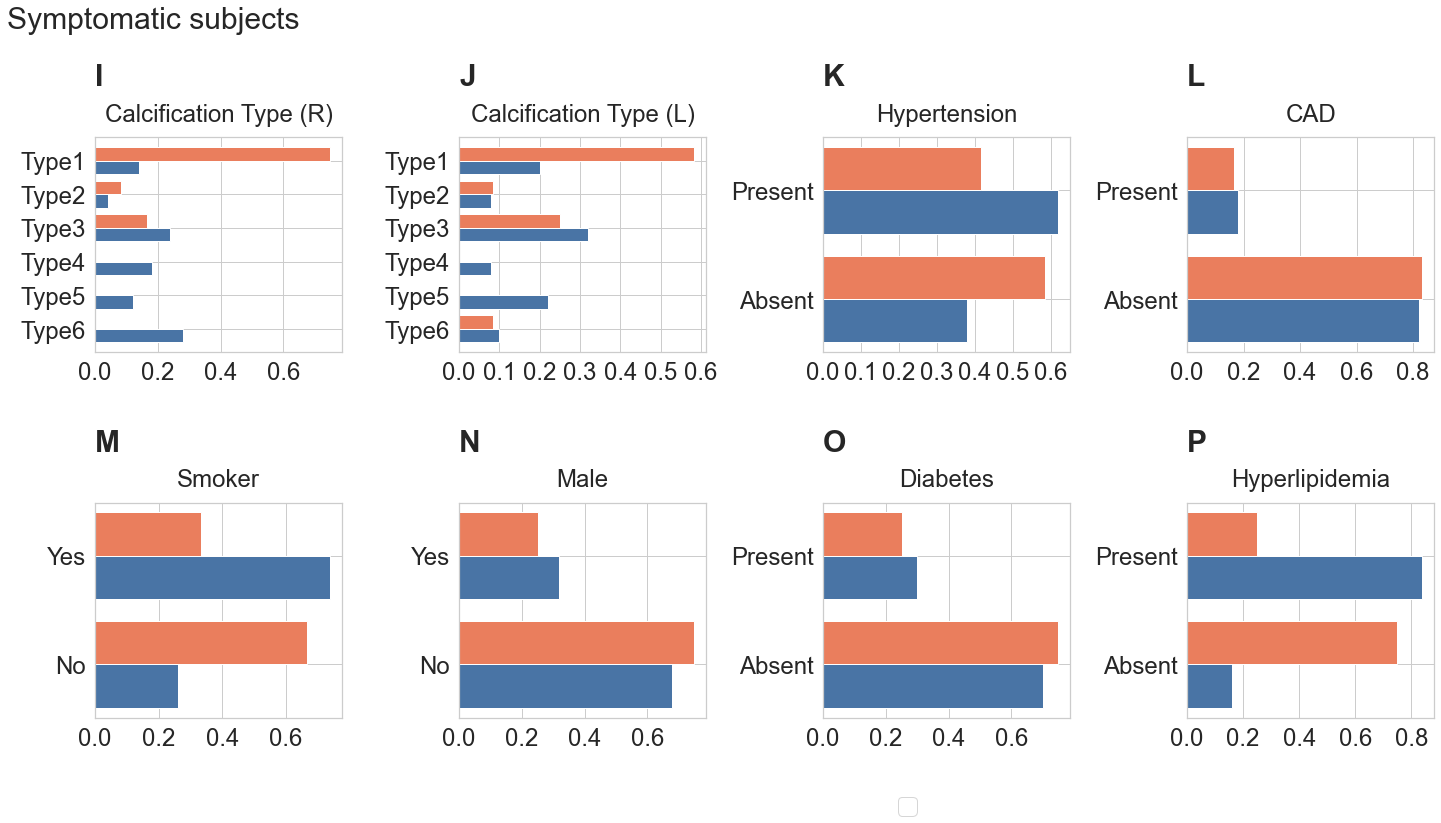

In [24]:
from string import ascii_uppercase

to_drop = ["Age", "Stenosis (L)", "Stenosis (R)", "Status"]
palette = {"Correct": blue_yonder, "Misclassified": sienna}

sns.set_theme(style="whitegrid")

f, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()

# false negatives
df = calcs[calcs.Status == 'Symptomatic'].drop(to_drop, axis=1)
calcs_melt_cat = pd.melt(df, id_vars="Category")

for c, ax in zip(calcs_melt_cat.variable.unique(), axes):
    col_data_with_ordering = calcs_melt_cat[calcs_melt_cat.variable==c]
    
    if "Calcification" in c:
        order = ["Type1", "Type2", "Type3", "Type4", "Type5", "Type6"]
    elif c in ["Smoker", "Male"]:
        order = ["Yes", "No"]
    else:
        order = ["Present", "Absent"]  
    col_data_with_ordering.loc[:, "value"] = pd.Categorical(col_data_with_ordering.loc[:, "value"], order).copy()
    

    sns.histplot(y="value",
                data=col_data_with_ordering,
                hue="Category",
                #order=order,
                palette=palette,
                stat="probability", common_norm=False,
                 multiple="dodge",
                 alpha=1,
                 shrink=.8,
                ax=ax)

    ax.set_title(c, pad=16)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.get_legend().remove()   


f.text(0, 1.02, "Symptomatic subjects", size=30, weight='normal')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(0.64, -0.03), 
         ncol=2, fontsize=16, prop={"size": 24})

for ax, letter in zip(axes, ascii_uppercase[8:]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
    
    ax.text(0, 1.24, letter, transform=ax.transAxes, size=30, weight='bold')

#axes[0].text(0, -1.8, "A", size=25, weight='bold')
#axes[8].text(0, -1.8, "B", size=25, weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)

plt.savefig("../output/plots/correct_vs_error_categorical_fn.tiff", format="tiff", dpi=500, 
            bbox_inches='tight', pil_kwargs={"compression": "tiff_lzw"})

In [246]:
axes[0].get_xticks()

array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. ])

A: asymptomatic, false positive errors
On the right carotid plaque, the errors are focused on patients having some type of calcification (type3-6),
on the left carotid plaque, type 3 and 4 have lots of errors
also, female gender, hyperlipidemia, no CAD, no diabetes

B: symptomatic, false negative errors
Both on the left and right carotid plaque, the vast majority of errors were made on patients without calcification (type1), 
also, female gender, hyperlipidemia, no CAD, no diabetes

# Make better tables 

## Categorical

### Asymptomatic and false negatives

In [208]:
fns_tns2 = fns_tns.copy()
fns_tns2 = fns_tns2.drop(["count_FNS", "freq_FNS", "count_TNS", "freq_TNS"], axis=1)
fns_tns2.columns = pd.MultiIndex.from_tuples(zip(
    ['False Asymptomatics', 'False Asymptomatics', "True Asymptomatics", "True Asymptomatics"], 
    ['Top', '%', 'Top', '%']))

fns_tns2.loc[:, ("False Asymptomatics", "%")] = fns_tns2.loc[:, ("False Asymptomatics", "%")].astype(np.float32)
fns_tns2.loc[:, ("True Asymptomatics", "%")] = fns_tns2.loc[:, ("True Asymptomatics", "%")].astype(np.float32)

fns_tns2.loc[:, ("False Asymptomatics", "%")] = fns_tns2.loc[:, ("False Asymptomatics", "%")].apply(lambda v: round(v, 1))
fns_tns2.loc[:, ("True Asymptomatics", "%")] = fns_tns2.loc[:, ("True Asymptomatics", "%")].apply(lambda v: round(v, 1))

fns_tns2

False Asymptomatics       True Asymptomatics      
                                       Top     %                Top     %
Calcification Type (R)               Type1  75.0              Type1  43.6
Calcification Type (L)               Type1  58.3              Type1  46.5
Hypertension                        Absent  58.3                yes  61.0
CAD                                 Absent  83.3                 no  81.9
Smoker                                  No  66.7                 no  56.7
Male                                    No  75.0             female  56.4
Diabetes                            Absent  75.0                 no  73.4
Hyperlipidemia                      Absent  75.0                yes  64.2

### Symptomatic and false positives

In [209]:
fps_tps2 = fps_tps.copy()
fps_tps2 = fps_tps2.drop(["count_FPS", "freq_FPS", "count_TPS", "freq_TPS"], axis=1)
fps_tps2.columns = pd.MultiIndex.from_tuples(zip(
    ['False Symptomatics', 'False Symptomatics', "True Symptomatics", "True Symptomatics"], 
    ['Top', '%', 'Top', '%']))

fps_tps2.loc[:, ("False Symptomatics", "%")] = fps_tps2.loc[:, ("False Symptomatics", "%")].astype(np.float32)
fps_tps2.loc[:, ("True Symptomatics", "%")] = fps_tps2.loc[:, ("True Symptomatics", "%")].astype(np.float32)

fps_tps2.loc[:, ("False Symptomatics", "%")] = fps_tps2.loc[:, ("False Symptomatics", "%")].apply(lambda v: round(v, 1))
fps_tps2.loc[:, ("True Symptomatics", "%")] = fps_tps2.loc[:, ("True Symptomatics", "%")].apply(lambda v: round(v, 1))
fps_tps2

False Symptomatics       True Symptomatics      
                                      Top     %               Top     %
Calcification Type (R)              Type1  30.6             Type3  32.7
Calcification Type (L)              Type1  32.3             Type3  33.5
Hypertension                      Present  58.1               yes  65.2
CAD                                Absent  91.9                no  80.1
Smoker                                Yes  59.7                no  51.2
Male                                   No  61.3            female  58.9
Diabetes                           Absent  79.0                no  75.4
Hyperlipidemia                    Present  82.3               yes  77.2

### Both

In [210]:
pd.merge(fns_tns2, fps_tps2, left_index=True, right_index=True).to_excel("../../Tables/dist_errors_cat.xlsx")

## Numeric

### Asymptomatics and false asymptomatics

In [211]:
fns_info_num2 = fns_info_num.copy()

fns_info_num2 = fns.describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)
tns_info_train_num2 = train[train.symptoms == "yes"].describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)

fns_tns_num2 = pd.merge(fns_info_num2, tns_info_train_num2, 
                       left_index=True, right_index=True,
                       suffixes=["_FNS", "_TNS"])

fns_tns_num2 = fns_tns_num2.drop(["std_FNS", "min_FNS", "max_FNS", "std_TNS", "min_TNS", "max_TNS"], axis=1)

fns_tns_num2.columns = pd.MultiIndex.from_tuples(zip(
    ['False Asymptomatics', 'False Asymptomatics', "True Asymptomatics", "True Asymptomatics"], 
    ['Mean', 'Median', 'Mean', 'Median']))

fns_tns_num2.loc[:, ("False Asymptomatics", "Mean")] = fns_tns_num2.loc[:, ("False Asymptomatics", "Mean")].apply(lambda v: round(v, 1))
fns_tns_num2.loc[:, ("True Asymptomatics", "Mean")] = fns_tns_num2.loc[:, ("True Asymptomatics", "Mean")].apply(lambda v: round(v, 1))

fns_tns_num2

False Asymptomatics        True Asymptomatics       
                            Mean Median               Mean Median
Age                         69.0   68.5               70.1   73.0
Stenosis (R)                43.8   45.0               40.1   25.0
Stenosis (L)                76.3   79.0               41.0   25.0

### Symptomatic and false symptomatic

In [212]:
fps_info_num2 = fps_info_num.copy()

fps_info_num2 = fps.describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)
tps_info_train_num2 = train[train.symptoms == "yes"].describe(include = np.number, 
                           percentiles = [.5]).T.drop("count", axis=1)

fps_tps_num2 = pd.merge(fps_info_num2, tps_info_train_num2, 
                       left_index=True, right_index=True,
                       suffixes=["_FPS", "_TPS"])

fps_tps_num2 = fps_tps_num2.drop(["std_FPS", "min_FPS", "max_FPS", "std_TPS", "min_TPS", "max_TPS"], axis=1)

fps_tps_num2.columns = pd.MultiIndex.from_tuples(zip(
    ['False Symptomatics', 'False Symptomatics', "True Symptomatics", "True Symptomatics"], 
    ['Mean', 'Median', 'Mean', 'Median']))

fps_tps_num2.loc[:, ("False Symptomatics", "Mean")] = fps_tps_num2.loc[:, ("False Symptomatics", "Mean")].apply(lambda v: round(v, 1))
fps_tps_num2.loc[:, ("True Symptomatics", "Mean")] = fps_tps_num2.loc[:, ("True Symptomatics", "Mean")].apply(lambda v: round(v, 1))

fps_tps_num2

False Symptomatics        True Symptomatics       
                           Mean Median              Mean Median
Age                        68.8   68.5              70.1   73.0
Stenosis (R)               47.1   47.5              40.1   25.0
Stenosis (L)               46.5   54.5              41.0   25.0

In [213]:
fps_tps_num2

False Symptomatics        True Symptomatics       
                           Mean Median              Mean Median
Age                        68.8   68.5              70.1   73.0
Stenosis (R)               47.1   47.5              40.1   25.0
Stenosis (L)               46.5   54.5              41.0   25.0

### Both

In [214]:
pd.merge(fns_tns_num2, fps_tps_num2, left_index=True, right_index=True).to_excel("../../Tables/dist_errors_cont.xlsx")